<a href="https://colab.research.google.com/github/modelflows/notebooks/blob/main/deep-learning/pod_dl_fixed_h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## POD-DL fixed horizon
Official implementation of the hybrid POD-DL model with fixed prediction horizon.

[R. Abadía-Heredia, M. Lopez-Martin B. Carro, J.I. Arribas, J.M. Pérez and S. Le Clainche. "A predictive hybrid reduced order model based on proper orthogonal decomposition combined with deep learning architectures." ESWA 10.1016/j.eswa.2021.115910 (2022)](https://doi.org/10.1016/j.eswa.2021.115910)

**Description**

POD-DL model, which combines proper orthogonal decomposition (POD) with deep learning (DL) models to predict the dynamics of a high-dimensional flow over a fixed time horizon defined by the ```out_seq``` variable.

A CPU can be used for a fast training of the POD-DL model, a GPU is not necessarily required. However, It requires a minimum system RAM of 51 GB.

The key hyperameters are the following:

* ```inp_seq``` (int)       -> Number (> 1) of samples that enter as input to the POD-DL model.
* ```out_seq``` (int)       -> Number (>= 1) of predictions computed by the POD-DL model at a time.
* ```batch_size``` (int)    -> Number (> 4) of samples that defines the batch size that is used for training.
* ```train_size``` (float)  -> Percentage of dataset to use for training the POD-DL model.

In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
import time
import hdf5storage
import scipy.io
from numpy import linalg as LA
import mat73

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM

# Hyperparameters

In [ ]:
inp_seq     = 10
out_seq     = 50
batch_size  = 12
train_size  = 0.5

# Load data

In [ ]:
f = scipy.io.loadmat('./cylind2D.mat')
dataset = f['Tensor']
print(dataset.shape)

(2, 199, 449, 151)


# Preprocessing

## Training/Test split

In [ ]:
dataset_mat = np.copy(dataset)
dataset_mat = np.reshape(dataset_mat, [-1, dataset_mat.shape[-1]], order = 'F')
print(dataset_mat.shape)

(178702, 151)


In [ ]:
train_set = np.copy(dataset_mat[..., :int(dataset.shape[-1] * train_size)])
test_set = np.copy(dataset_mat[..., int(dataset.shape[-1] * train_size):])

## Singular Value Decomposition

In [ ]:
mean_flow = np.mean(train_set, axis = -1, keepdims = True)

U, S, VT = np.linalg.svd(train_set - mean_flow, full_matrices = False)

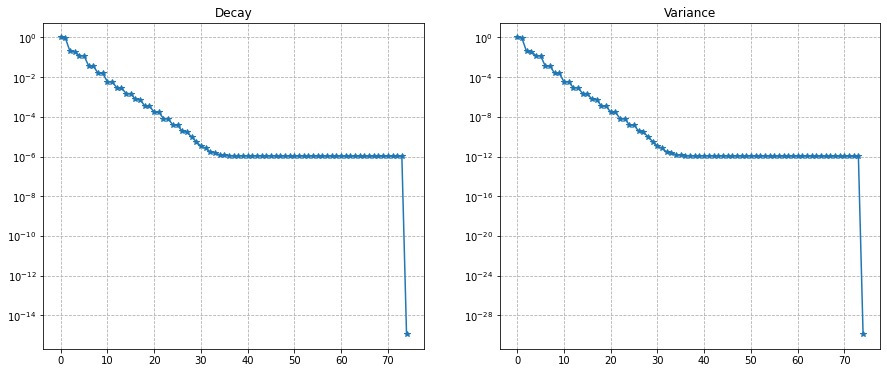

In [ ]:
plt.close('all')

fig, axs = plt.subplots(1, 2, figsize = (15, 6))

axs[0].semilogy(S / S[0], '-*')
axs[0].set_title("Decay")
axs[0].grid(True, linestyle = '--')

_ = S**2 / (len(S) - 1)

axs[1].semilogy(_ / _[0], '-*')
axs[1].set_title("Variance")
axs[1].grid(True, linestyle = '--')

In [ ]:
num_modes = 20

S = np.diag(S[:num_modes])

U = U[:, :num_modes]
VT = VT[:num_modes, :]

## Data scaling

In [ ]:
decision2 = 'standardization'

if decision2 == 'no-scaling':

    tensor_norm = VT

elif decision2 == 'range':

    min_val = np.amin(VT)
    range_val = np.ptp(VT)
    tensor_norm = (VT - min_val) / range_val

elif decision2 == 'standardization':

    med_val = np.mean(VT)
    std_val =np.std(VT)
    tensor_norm = (VT - med_val) / std_val

elif decision2 == 'MaxPerMode':

    max_val = sum(np.amax(np.abs(VT), axis = 1))
    tensor_norm = VT / max_val

In [ ]:
def reverse_scaling(decision2, tensor):

    if decision2 == 'no-scaling':

        tensor_renorm = tensor

    elif decision2 == 'range':

        tensor_renorm = tensor * range_val + min_val

    elif decision2 == 'standardization':

        tensor_renorm = tensor * std_val + med_val

    elif decision2 == 'MaxPerMode':

        tensor_renorm = tensor * max_val

    return tensor_renorm

In [ ]:
# Dataset configuration
total_length = tensor_norm.shape[1]
channels_n = 0
dim_x = tensor_norm.shape[0]
dim_y = 0

print('\n-----------------------------')
print('Dataset configuration: \n')
print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)


-----------------------------
Dataset configuration: 

total_length:  75
channels_n:  0
dim_x:  20
dim_y:  0


## Rolling window

In [ ]:
# Data generator
import math
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, list_IDs, batch_size=5, dim=(20),
                k = 624, p = 1,
                shuffle=True, till_end = False, only_test = False):
        'Initialization'
        self.data = data
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.p = p
        self.k = k
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.till_end:
            lenx = math.ceil((len(self.list_IDs) / self.batch_size))
        else:
            lenx = int(np.floor(len(self.list_IDs) / self.batch_size))
        return lenx

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        if self.only_test:
            return X
        else:
            return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, depth)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.k))
        y = [np.empty((self.batch_size, self.dim))]*self.p

        y_inter = np.empty((self.batch_size, self.dim, self.p))

        # Generate data
        lenn = len(list_IDs_temp)
        for i, ID in enumerate(list_IDs_temp):
            # Store Xtrain
            X[i,:,:] = self.data[:,ID:ID+self.k]
            # Store Ytrain
            y_inter[i,:,:] = self.data[:,ID+self.k:ID+self.k+self.p]

        for j in range(self.p):
            y[j] = y_inter[:,:,j]
            y[j] = np.reshape(y[j], (lenn, -1), order = 'F')

        X = X.transpose((0,2,1))

        return X, y

In [ ]:
stride_train = 1
stride_val = 1
stride_test = 1

dim=(dim_x)

test_length = test_set.shape[-1]
train_length = test_set.shape[-1]

if int(train_length-(inp_seq + out_seq)) < 0:
    train_n = 0
elif int((train_length-(inp_seq + out_seq))//stride_train) == 0:
    train_n = 1
else:
    train_n = int((train_length-(inp_seq + out_seq))//stride_train)

if int(test_length-(inp_seq + out_seq)) < 0:
    test_n = 0
elif int((test_length-(inp_seq + out_seq))//stride_test) == 0:
    test_n = 1
else:
    test_n = int((test_length-(inp_seq + out_seq))//stride_test)

train_idxs = np.empty([train_n], dtype='int')
test_idxs = np.empty([test_n], dtype='int')

j = 0
for i in range(train_n):
    train_idxs[i] = j
    j = j+stride_train

j = 0
for i in range(test_n):
    test_idxs[i] = j
    j = j+stride_test

# Generators
training_generator = DataGenerator(
    tensor_norm,
    train_idxs,
    dim = dim,
    batch_size = batch_size,
    k = inp_seq,
    p = out_seq,
    till_end = False,
    only_test = False,
    shuffle = True
)

test_generator = DataGenerator(
    tensor_norm,
    test_idxs,
    dim = dim,
    batch_size = batch_size,
    k = inp_seq,
    p = out_seq,
    till_end = False,
    only_test = True,
    shuffle = False
)

In [ ]:
print('\n-----------------------------')
print('Model training summary: \n')
print ('test_length: ', test_length)
print ('train_length: ', train_length)
print()
print('Number mini-batches for testing: ', len(test_generator))
print('Number mini-batches for training: ', len(training_generator))


-----------------------------
Model training summary: 

test_length:  76
train_length:  76

Number mini-batches for testing:  1
Number mini-batches for training:  1


# LSTM model

In [ ]:
def create_model(in_shape, out_dim, p, neurons, shared_dim, act_fun, act_func2,
    lr, lf
):

    tf.keras.backend.clear_session()


    x = Input(shape=in_shape)


    v = LSTM(neurons)(x)

    v = Dense(p * neurons, activation = act_fun)(v)

    v = Reshape((p, neurons))(v)
    tt = [1]*p

    r = TimeDistributed( Dense(shared_dim, activation=act_fun))(v)
    s = tf.split(r, tt, 1)
    for i in range(p):
        s[i] = Flatten()(s[i])

    o = []
    for i in range(p):
        o.append( Dense(out_dim, activation=act_func2)(s[i]) )

    m = Model(inputs=x, outputs=o)
    opt = keras.optimizers.Adam(learning_rate=lr)
    m.compile(loss=lf, optimizer=opt, metrics=[lf])

    return(m)

In [ ]:
#create the model

in_shape = [inp_seq, dim_x]
out_dim = dim_x
shared_dim = 80
neurons = 200
lr = 1e-3
lf = 'mse'

model = create_model(
    in_shape,
    out_dim,
    out_seq,
    neurons,
    shared_dim,
    'relu',
    'linear',
    lr,
    lf
)

print('\nModel Summary:\n')
model.summary()


Model Summary:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 20)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 200)          176800      ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 10000)        2010000     ['lstm[0][0]']                   
                                                                                                  
 reshape (Reshape)              (None, 50, 200)      0           ['dense[0][0]']                  
                                                                             

In [ ]:
# save the best weights
save_string = 'saved_models/' + 'hybrid_dl'

# save the best weights
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'

# Training

In [ ]:
# Training
np.random.seed(247531338)
t0 = time.time()
# Model training
callbacks = [
    ModelCheckpoint(save_best_weights, monitor='loss', save_best_only=True, mode='auto'),
    # EarlyStopping(monitor='loss', patience = 50, verbose = 1, mode = 'auto', min_delta = 0.0001)
    ]

print('\nTraining Model Please Wait...\n')

history = model.fit(
    training_generator,
    epochs = 300,
    callbacks = callbacks
)

t1 = time.time()
print('\nModel Trained Successfully!')

print(f"\nTraining complete. Time elapsed: {np.round(((t1 - t0) / 60.), 2)} minutes")


Training Model Please Wait...

Epoch 1/300
1/1 [==============================] - 8s 8s/step - loss: 53.0721 - dense_2_loss: 1.0813 - dense_3_loss: 1.1138 - dense_4_loss: 1.1418 - dense_5_loss: 1.1768 - dense_6_loss: 1.2133 - dense_7_loss: 1.2338 - dense_8_loss: 1.2359 - dense_9_loss: 1.2318 - dense_10_loss: 1.2042 - dense_11_loss: 1.1729 - dense_12_loss: 1.1371 - dense_13_loss: 1.1059 - dense_14_loss: 1.0727 - dense_15_loss: 1.0410 - dense_16_loss: 1.0126 - dense_17_loss: 0.9973 - dense_18_loss: 0.9721 - dense_19_loss: 0.9388 - dense_20_loss: 0.9017 - dense_21_loss: 0.8700 - dense_22_loss: 0.8395 - dense_23_loss: 0.8309 - dense_24_loss: 0.8394 - dense_25_loss: 0.8711 - dense_26_loss: 0.9070 - dense_27_loss: 0.9368 - dense_28_loss: 0.9727 - dense_29_loss: 1.0100 - dense_30_loss: 1.0379 - dense_31_loss: 1.0664 - dense_32_loss: 1.0710 - dense_33_loss: 1.1092 - dense_34_loss: 1.1359 - dense_35_loss: 1.1731 - dense_36_loss: 1.2061 - dense_37_loss: 1.2330 - dense_38_loss: 1.2331 - dense_39

# Plot loss function

In [ ]:
summary_stats = pd.DataFrame({
    'epoch': [ i + 1 for i in history.epoch ],
    'train_loss': history.history['loss']
})

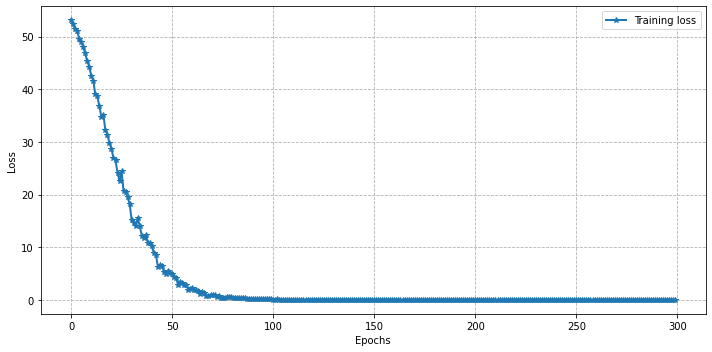

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(summary_stats.train_loss, '-*', label = 'Training loss', linewidth = 2)
ax.grid(True, linestyle = '--')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

fig.tight_layout()

figName = "loss_evolution_hybrid_dl.jpg"
plt.savefig(figName, format = 'jpg')
plt.show()

# Forecasting

In [ ]:
last_seq = tensor_norm.T[None, -inp_seq:, :]

model.load_weights(save_best_weights)

pred = model.predict(last_seq, verbose = 0)
pred = np.stack(pred, axis = 1)
pred = pred[0, ...].T

pred = reverse_scaling(decision2, pred)

predictions = U @ S @ pred
predictions += mean_flow
predictions = np.reshape(predictions, [*dataset.shape[:-1], out_seq], order = 'F')

del pred

Text(0.5, 1.0, 'Forecasting')

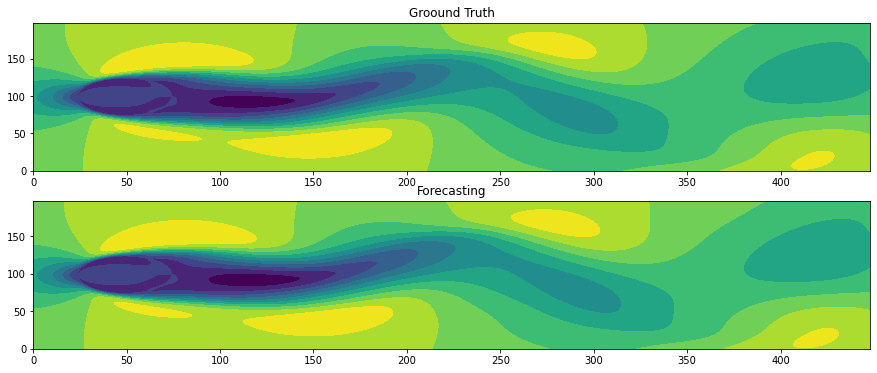

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (15, 6))

snap = 49

vmin = dataset[0,:,:,tensor_norm.shape[-1] + snap].min()
vmax = dataset[0,:,:,tensor_norm.shape[-1] + snap].max()

axs[0].contourf(dataset[0,:,:,tensor_norm.shape[-1] + snap], 12, vmax = vmax, vmin = vmin)
axs[0].set_title('Groound Truth')
axs[1].contourf(predictions[0,:,:,snap], 12, vmax = vmax, vmin = vmin)
axs[1].set_title('Forecasting')